## Estimating US crude exports

In this notebook we have implemented a model to track real-time U.S. crude exports. The official US crude exports figures are available from U.S. Energy Information Administration (EIA). However, these figures are published with a 2-3 months delay. In the world of alternative data sources, could we reliably estimate U.S. crude exports ahead of the official figures? In this example we're using trade flows data retrieved using [LDMS (LSEG Data Management Solution)](https://developers.lseg.com/en/api-catalog/ldms/ldms) to gain insight into crude oil supply trends and buying patterns. We also create a basic arbitrage model using crude prices and freight rates to assess when U.S. crude is more favourable compared to Middle Eastern crude for a crude buyer in Asia. Finally we use fixtures to assess the forward view of exports from the U.S. Gulf.  
The notebooks utilizes the following Python packages:  
- LSEG Data library to retrieve for pricing information from the Data Platform
- JSON, requests and configparser are used for getting LDMS information
- Plotly are used for plotting
- Other standard python packages such as pandas are used for data manipulation

In [1]:
import datetime as dt
import requests
import json
import configparser
import lseg.data as ld
import pandas as pd
import numpy as np
from datetime import date,timedelta
import csv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

ld.open_session()

<lseg.data.session.Definition object at 0x19bcc8fb190 {name='workspace'}>

## Retrieving trade flow data from LDMS. 
LDMS is an open platform that allows you to integrate the great depth and breadth of LSEG’s commodity data into your workflows. LDMS merges and normalizes data across a range of sources including LSEG, 3rd party and internal customer's data. LSEG sources available through LDMS include our Real-Time datafeed, DataScope Select and Pointconnect feeds. Client application can conveniently retrieve this data using a standard REST API.  
  
We start by retrieving the data for Dirty flows with Load Country as USA/Virgin Islands and Crude Oil as the Product. We also load Canada pipeline imports data, which we will later add to tanker crude flows originating from U.S. ports to estimate total U.S. crude exports. Static CSV file with U.S. ports locations is used to display port locations on the map.

In [2]:
#A config file with the LDMS api key is stored and accessed separately
config = configparser.ConfigParser()
config.read('config.ini')
api=config['LDMS']['Api']
headers = { 'Authorization' : config['LDMS']['Key'],'Accept':"text/csv" }
#params
flowType = 'Dirty'
fields = '*'
filter = 'LoadCountry=United States,Virgin Islands (U.S.);Product=Crude Oil'
result = requests.get(api + '/Flows/FlowData/'+flowType+'?Fields='+fields+'&Filter='+filter, headers=headers, verify=True)
flows = open('USflows.csv', "w")
flows.write(result.text)
flows.close()
df=pd.read_csv('USflows.csv', parse_dates=True, infer_datetime_format=True)
port_locations=pd.read_csv("US_Ports_Locations.csv")
canada_imports=pd.read_csv("Canada Pipeline Imports.csv",parse_dates=True,index_col='Bbls',thousands=',')
canada_imports.index=canada_imports.index.to_period('M')
#Display a sample of flows data we'll be analizing
df[['Departure Date','Vessel','Vessel Type','Load Port','Discharge Port','Barrels','Status']].tail(10)

,Departure Date,Vessel,Vessel Type,Load Port,Discharge Port,Barrels,Status
48951,2025-05-08 06:16:35,FRONT NAUSTA,VLCC,Pacific Lightering Area 2,NaN,900416,Vessel Underway
48952,2025-05-08 06:16:35,FRONT NAUSTA,VLCC,Pacific Lightering Area 2,NaN,900416,Vessel Underway
48953,2025-06-10 02:00:00,POLAR RESOLUTION,Suezmax,Valdez,NaN,877146,Vessel Ballasting
48954,2025-06-10 02:00:00,POLAR RESOLUTION,Suezmax,Valdez,NaN,877146,Vessel Ballasting
48955,2025-06-10 19:00:00,POLAR ENTERPRISE,Suezmax,Valdez,NaN,877146,Vessel Ballasting
48956,2025-06-10 19:00:00,POLAR ENTERPRISE,Suezmax,Valdez,NaN,877146,Vessel Ballasting
48957,2025-06-04 01:01:55,SEALOYALTY,Aframax / LRII,St Croix,St Eustatius,592039,Vessel Underway
48958,2025-06-04 01:01:55,SEALOYALTY,Aframax / LRII,St Croix,St Eustatius,592039,Vessel Underway
48959,2025-07-01 00:00:00,LONDON VOYAGER,VLCC,NaN,NaN,1979883,Subs
48960,2025-07-01 00:00:00,LONDON VOYAGER,VLCC,NaN,NaN,1979883,Subs


In [3]:
df = df[(df['Departure Date'] > '2014-12-31') & (df['Departure Date'] < '2021-06-01')]

To produce an estimate for monthly crude exports we need to aggregate the flows into time intervals. For this purpose it's useful to add a number of columns detailing departure and arrival week, month, quarter and year.

In [4]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'], errors='coerce')
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], errors='coerce')
df['Departure Week Number']=df['Departure Date'].dt.isocalendar().week
df['Departure Week']=pd.to_datetime(df['Departure Date']).dt.to_period('W')
df['Departure Month']=pd.to_datetime(df['Departure Date']).dt.to_period('M')
df['Departure Quarter']=pd.to_datetime(df['Departure Date']).dt.to_period('Q')
df['Departure Year']=pd.to_datetime(df['Departure Date']).dt.to_period('Y')
df['Arrival Week Number']=df['Arrival Date'].dt.isocalendar().week
df['Arrival Week']=pd.to_datetime(df['Arrival Date']).dt.to_period('W')
df['Arrival Month']=pd.to_datetime(df['Arrival Date']).dt.to_period('M')
df['Arrival Quarter']=pd.to_datetime(df['Arrival Date']).dt.to_period('Q')
df['Arrival Year']=pd.to_datetime(df['Arrival Date']).dt.to_period('Y')

Now we analyze the flows by geography.  
Myanmar discharges are treated as imports by China as the Sino-Myanmar pipeline feeds the refineries in China provinces bordering Myanmar.  
The trade flows data includes all crude transport. At the moment there's only one U.S. facility (The Louisiana Offshore Oil Port or LOOP) able to accommodate a fully loaded VLCC (Very Large Crude Carrier), a type of oil tanker able to carry approximately 2 mln barrels of crude oil and required for economic transportation of crude across the ocean, such as between the U.S. and Asia. All onshore U.S. ports in the Gulf Coast that actively trade petroleum are located in inland harbors and are connected to the open ocean through shipping channels or navigable rivers. Although these channels and rivers are regularly dredged to maintain depth and enable safe navigation for most ships, they are not deep enough for deep-draft vessels such as fully loaded VLCCs. To circumvent depth restrictions, VLCCs transporting crude oil to or from the U.S. Gulf Coast have typically used partial loadings and the process of ship-to-ship transfers or lightering. To accurately estimate U.S. crude exports, we need to account for lightering in our analysis of trade flows data, to avoid double counting crude first transported in a smaller tanker from a U.S. onshore port to an offshore lightering zone and then transferred to a larger tanker for trasporting to its ultimate destination port. To account for this we have compiled a list of loading and discharge ports to exclude from the trade flows dataset:  
<br />
<div>
<table align="left">
    <tr><th style="text-align:left"> Port Name</th><th style="text-align:left"> Port RIC</th></tr>
    <tr><td style="text-align:left"> Pacific Area Lightering</td><td style="text-align:left"> C}TS7309641681</td></tr>
    <tr><td style="text-align:left"> South Sabine Point</td><td style="text-align:left"> C}TS7309533579</td></tr>
    <tr><td style="text-align:left"> US Golf Lightering Zones</td><td style="text-align:left"> C}TS7309533561</td></tr>
    <tr><td style="text-align:left"> Calcasieu Pass (S) Anchorage</td><td style="text-align:left"> C}TS7309786001</td></tr>
    <tr><td style="text-align:left"> Pacific Lightering Area 2</td><td style="text-align:left"> C}TS7309709063</td></tr>
    <tr><td style="text-align:left"> Gulf Gateway Terminal</td><td style="text-align:left"> C}TS7309557398</td></tr>
    <tr><td style="text-align:left"> Corpus Christi STS Area 2</td><td style="text-align:left"> C}TS7309789693</td></tr>
    <tr><td style="text-align:left"> Pascaguola Lightering Zone</td><td style="text-align:left"> C}TS7309823983</td></tr>
    <tr><td style="text-align:left"> GOLA - Galveston Offshore Lightering Area</td><td style="text-align:left"> C}TS7309564485</td></tr>
    <tr><td style="text-align:left"> Gulfmex (SW Pass) Lightering</td><td style="text-align:left"> C}TS7309533587</td></tr>
    <tr><td style="text-align:left"> Southwest Pass Lightering Area</td><td style="text-align:left"> C}TS7309791374</td></tr>
    <tr><td style="text-align:left"> Corpus Christi STS 1</td><td style="text-align:left"> C}TS7309944668</td></tr>
</table>
</div>
<div style="clear:both">
<br />
Flows are segregated based on their load and discharge port/berth characteristics to avoid double counting of ship-to-ship (STS) loads. Only STS loads with discharge country other than US/Virgin Islands and shore loads with discharge country other than US/Virgin Islands are counted towards exports. Vessels with status as Underway, Discharged, Discharging or Awaiting Discharge are departed flows and are included in the count.
</div>

In [5]:
df['Adjusted Discharge Country']=np.where(df['Discharge Country']=='Myanmar','China',df['Discharge Country'])
sts_port_exclusion_list=['C}TS7309641681','C}TS7309533579','C}TS7309533561','C}TS7309786001','C}TS7309709063','C}TS7309557398',
                         'C}TS7309789693','C}TS7309823983','C}TS7309564485','C}TS7309533587','C}TS7309791374','C}TS7309944668']
df['Loadport_exclusion']=np.where(df['Load Port RIC'].isin(sts_port_exclusion_list),1,0)
df['Disport_exclusion']=np.where(df['Load Port RIC'].isin(sts_port_exclusion_list),1,0)
df['Discharge_country']=np.where(df['Discharge Country'].isin(['United States','Virgin Islands (U.S.)']),1,0)
df['Flow_exclusion']=np.where((df['Discharge_country']==0)&(df['Loadport_exclusion']==0),1,
                              np.where((df['Discharge_country']==0)&(df['Loadport_exclusion']==1),1,0))
us_exports=df[df['Flow_exclusion']==1]
us_exports=us_exports[us_exports['Status'].isin(['Vessel Underway','Vessel Discharged','Vessel Discharging','Vessel Awaiting Discharge'])]
zones=pd.read_csv("ports_zones.csv")
merged_df=us_exports.merge(zones,how='left',left_on='Load Port RIC',right_on='Ric')
merged_df=merged_df.merge(port_locations,how='left',left_on='Load Port RIC',right_on='Instrument')

In the cell above we added port zone info to the dataframe. This allows us to demonstrate that trade flows analysis can be done for a specific PADD. In this example we're only going to consider PADD 3 exports, which account for the bulk of U.S. crude exports. To achieve this we're filtering flows with Tanker zone as US Gulf. Then we can pivot the table to aggregate the flow by departure month and add Canada imports via pipelines.

In [6]:
padd3=merged_df[merged_df['Tanker Zone']=='US Gulf']
padd3_table=padd3.pivot_table(index='Departure Month',values='Barrels',aggfunc=np.sum,fill_value=0)
padd3_table=padd3_table.merge(canada_imports['PADD 3'],how='left',left_index=True,right_index=True)
padd3_mnbpd=padd3_table.copy()
padd3_mnbpd['days']=np.where(padd3_mnbpd.index!=pd.Timestamp(dt.datetime.today()).to_period('M'),padd3_mnbpd.index.days_in_month,dt.datetime.today().day)
padd3_mnbpd['mnbpd']=padd3_mnbpd.iloc[:,0]/(padd3_mnbpd['days'])
padd3_mnbpd['LSEG Flows_kbpd']=padd3_mnbpd['mnbpd']/1000
padd3_mnbpd['Pipeline exports_kbpd']=padd3_mnbpd['PADD 3']/1000/(padd3_mnbpd['days'])
padd3_mnbpd.drop(columns='days',inplace=True)
print(padd3_mnbpd.tail())

                   Barrels     PADD 3         mnbpd  LSEG Flows_kbpd  \
Departure Month                                                        
2021-01          181258786  7979270.0  5.847058e+06      5847.057613   
2021-02          120325446        NaN  4.297337e+06      4297.337357   
2021-03          141257496        NaN  4.556693e+06      4556.693419   
2021-04          176108758        NaN  5.870292e+06      5870.291933   
2021-05          148992032        NaN  4.806195e+06      4806.194581   

                 Pipeline exports_kbpd  
Departure Month                         
2021-01                     257.395806  
2021-02                            NaN  
2021-03                            NaN  
2021-04                            NaN  
2021-05                            NaN  


To visualize how well our estimated PADD 3 exports compare to the official figures from EIA, we're using the Data Library to retrieve the historical data of EIA U.S. PADD 3 crude oil exports, construct a comparison table and plot the timeseries.

In [7]:
eia=ld.get_history('EXP-CLPD3D-EIA',start='2015-01-01', end='2025-05-30', interval='monthly')
eia.index=eia.index.to_period('M')
compare=padd3_mnbpd.merge(eia,how='left',left_index=True,right_index=True)
compare['PADD3_calculated']=compare['LSEG Flows_kbpd']+compare['Pipeline exports_kbpd']
compare.index=compare.index.astype('str')
compare['COMM_LAST']=compare['COMM_LAST'].astype('float64')
fig_benchmarking=compare[['LSEG Flows_kbpd','Pipeline exports_kbpd']].iplot(kind='bar',barmode='stack',title='Comparison of EIA and LSEG Oil Research flows for US PADD 3 Crude Oil exports',asFigure=True)
fig_benchmarking.add_trace(trace=go.Scatter(x=compare.index,y=compare['COMM_LAST'],name='EIA PADD3',line=dict(color='lime')))
fig_benchmarking.show()

As one can clearly see from the chart, LSEG Flows data for seaborne exports historically tracks the official EIA figures with very high degree of accuracy. The advantage of our estimate over official EIA data is of course that our estiate can be performed in real-time.

### Visualising the impact of export infrastructure addition on exports from PADD 3  
In this analysis we're using Trade Flows data to visualize the impact of the addidion of the new export infrastructure including pipelines and terminals over the last few years. 

In [8]:
map_data=merged_df.pivot_table(index=['Departure Year','Load Port'],values='Barrels',aggfunc=np.sum)
map_data=map_data.reset_index()
map_data=map_data.merge(port_locations[['Latitude','Longitude','Name']],how='left',left_on='Load Port',right_on='Name')
map_data['Depyear']=map_data['Departure Year'].astype('str')
#map_data['Depyear']=pd.to_datetime(map_data['Depyear'])
#map_data['Depyear']=map_data['Depyear'].astype('str')
fig_export_infra=px.scatter_geo(map_data,lat='Latitude',lon='Longitude',size='Barrels',projection='albers usa',animation_frame='Depyear',hover_name='Load Port')
fig_export_infra.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig_export_infra.show()

In this visual we can see the story of how U.S. crude exports from the Gulf of Mexico ports grew from 2015 to 2020. Before 2015 U.S. was primarily importing oil and was exporting very little of it. The legislation enacted in 2015 authorized the export of U.S. crude without a license. This legislation combined with shale production boom resulted in the U.S. producers starting to export significant amounts of oil to get better value in international markets, particular from countries with significant demand for light sweet crude. We can also see that it took a couple of years for the export volumes to pick up. This is because the traditionally import oriented infrastructure had to catch up with the demand for exports. It's interesting to note how Corpus Christi became a major loading port for U.S. crude exports with addition of new export infrastructure including pipelines from the Permian basin and new terminals.

### Top regions where U.S. crude flows to
In the following visualization we can see where the U.S. crude flows to and how the flows evolved over the last 3 years. It's very clear that the emphasis on the top 4 Asian buyers: China, India, South Korea and Japan has been increasing.

In [9]:
sankey_data=merged_df[merged_df['Tanker Zone']=='US Gulf']
regions=pd.read_csv('Regions.csv')
sankey_data=sankey_data.merge(regions,how='left',left_on='Adjusted Discharge Country',right_on='Country')
sankey_data=sankey_data.pivot_table(index=['Departure Year','Region'],values='Barrels',aggfunc=np.sum)
sankey_data=sankey_data.reset_index()
sankey_data['Departure Year']=sankey_data['Departure Year'].astype('str')
sankey_data=sankey_data[sankey_data['Departure Year'].isin(['2018','2019','2020','2021'])]
labels=sankey_data['Departure Year'].drop_duplicates().to_list()
labels.extend(sankey_data['Region'].drop_duplicates().to_list())
source=list()
target=list()
values=list()
for index,rows in sankey_data.iterrows():
    source.append(labels.index(rows['Departure Year']))
    target.append(labels.index(rows['Region']))
    values.append(rows['Barrels'])
sankey = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue",
      hovertemplate='%{value} bbls',
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = values,
      hovertemplate='%{value} bbls',
        
  ))])

sankey.update_layout(title_text="Export destinations of crude oil exported from PADD 3", font_size=10)
sankey.show()

### How the key customers have changed over time

In [10]:
iso=pd.read_csv("country_code_web.csv")
merged_df=merged_df.merge(iso,left_on='Discharge Country',right_on='Load Country')
discharge_countries=merged_df.pivot_table(index=['Departure Year','Adjusted Discharge Country'],values='Barrels',aggfunc=np.sum)
discharge_countries.reset_index(inplace=True)
discharge_countries=discharge_countries.merge(iso,left_on='Adjusted Discharge Country',right_on='Load Country')
discharge_countries['Depyear']=discharge_countries['Departure Year'].astype('str')
discharge_countries['Depyear']=discharge_countries['Depyear'].astype('int')
fig_exports_destinations=px.scatter_geo(discharge_countries,locations='ISO ALPHA-3 code',size='Barrels',color='Barrels',color_continuous_scale='Brwnyl',animation_frame='Depyear',hover_name='Adjusted Discharge Country')
fig_exports_destinations.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 2000
fig_exports_destinations.show()

Exports originally limited to Canada picked up pace to other parts of the world especially to North-West Europe and Asia starting in 2017 and 2018. As Chinese refining capacity grew, the demand for U.S. crude steadily increased till 2019 when the trade wars caused a sharp drop in the imports by China. While the volumes went to South Korea and India, this raised a lot of friction between the USA and China. In 2020, the 2 countries agreed on a mechanism to resolve the trade dispute under which China was to reduce the trade deficit by purchasing increased value of energy commodities. That, coupled with the sharp decoupling of WTI prices during Covid-19 related crash, led to a strong rebound in 2020 volumes.

### Using Fixtures data to forecast crude exports. 
Finally we're going to see if fixtures data could be a predictor of U.S. crude exports. We retrieve LSEG Fixtures data through LDMS API call and combining it with our estimates of crude exports from PADD 3 we compiled before using trade flows.

In [11]:
fixturesType = 'Tanker'
fields = '*'
headers = { 'Authorization' : config['LDMS']['Key'],'Accept':"text/csv" }
result = requests.get(api + '/Fixtures/FixtureData/'+fixturesType+'?Fields='+fields, headers=headers, verify=True)
fixtures = open('Fixtures.csv', "w")
fixtures.write(result.text)
fixtures.close()
fixtures_df=pd.read_csv('Fixtures.csv',parse_dates=True,infer_datetime_format=True, encoding='latin-1')

In [12]:
filtered_fixtures_df=fixtures_df[fixtures_df['Load Zone']=='US Gulf']
filtered_fixtures_df=filtered_fixtures_df[filtered_fixtures_df['Commodity']=='Crude Oil']
filtered_fixtures_df['Laycan Month']=pd.to_datetime(filtered_fixtures_df['Laycan From']).dt.to_period('M')
fix_pivot=filtered_fixtures_df.pivot_table(index='Laycan Month',values='Cargo Size',aggfunc=np.sum)
fix_pivot=fix_pivot.merge(padd3_mnbpd,how='left',left_index=True,right_index=True)
fix_pivot.drop(columns=['PADD 3','mnbpd','Pipeline exports_kbpd'],inplace=True)
fix_pivot['Cargo Size']=fix_pivot['Cargo Size']*7.3 #Converting from Tonnes to Barrels using BPT
fix_pivot=fix_pivot.loc[pd.Period('2020-01'):]
fix_pivot.index=fix_pivot.index.astype('str')

In [13]:
fp_20 = fix_pivot[['2020-' in s for s in fix_pivot.index]]
fp_21 = fix_pivot[['2021-' in s for s in fix_pivot.index]]
fix_pivot = pd.concat([fp_20, fp_21])

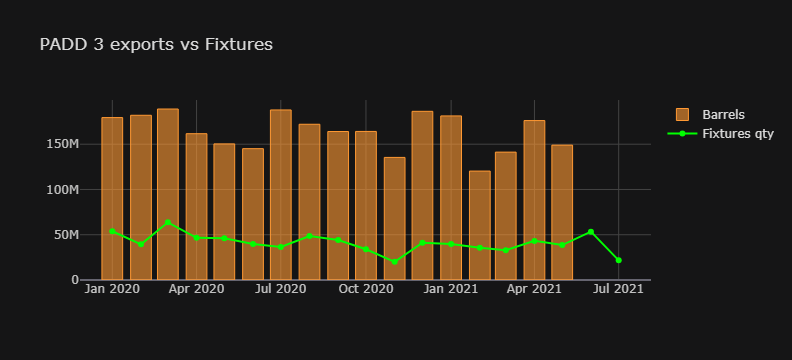

In [14]:
fig_fix=fix_pivot[['Barrels']].iplot(kind='bar',title='PADD 3 exports vs Fixtures',asFigure=True)
fig_fix.add_trace(trace=go.Scatter(x=fix_pivot.index,y=fix_pivot['Cargo Size'],name='Fixtures qty',line=dict(color='lime')))

What we can see from this chart is that LSEG Fixtures show good correlation with estimated crude exports from PADD 3, and can be reasonably used as a predictor of the direction or trend of U.S. crude exports. Similar analysis can be done for other regions or commodities.